# Маркетинговый анализ поиска причин убытков развлекательного приложения Procrastinate Pro+ 

## Описание проекта (#description_project)
<a id="description_project"></a>

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.

*Цель исследования:*
1. Проанализировать причины низкой окупаемости рекламы.
2. Найти `cлабые места` и найти решения для увеличения эффективности продвижения.
3. Описать рекомендации по корректировке рекламной стратегии для отдела маркетинга.

*Ход исследования:*
1. Загрузка и оценка качества данных .
2. Предобработка и корректировка полученных данных.
3. Подготовка аналитических таблиц.
4. Расчет метрик и визуализация динамики ключевых показателей маркетинговой кампании.
5. Поиск причин низкой окупаемости, защита предлагаемых корректировок с помощью таблиц и графиков.
6. Подготовка рекомендаций для отдела маркетинга. 


## Описание данных (#description_data)

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.
В процессе поиска предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

Заказчиком предоставлена информация в трёх датасетах. Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о заказах, а `costs_info_short.csv` — информацию о расходах на рекламу.  

Структура `visits_info_short.csv`:
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.  

Структура `orders_info_short.csv`:
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.  

Структура `costs_info_short.csv`:
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.


## Настройка параметров анализа 
### Импорт библиотек и настройка параметров (#settings)
<a id="settings"></a>

In [1]:
from IPython.display import HTML

HTML(
    """
     <script>
        code_show=true;
        function code_toggle() {
            if (code_show){
             $('div.input').hide();
                            } else {
                                    $('div.input').show();
                                    }
            code_show = !code_show
                                }
            $( document ).ready(code_toggle);
    </script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
     """
)

In [2]:
# Импортирую все необходимые библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px

plt.rcParams["figure.figsize"] = (20, 5)

c:\Users\suley\.conda\envs\practicum\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Функции (#functions)
<a id="functions"></a>

#### Функции для группировки данных и построения сводных таблиц

- `get_count_and_share` — функция для расчёта количества и доли платящих пользователей
- `get_pivot_table` — функция для расчёта суммы и доли рекламных расходов

In [3]:
def get_count_and_share(df: pd.DataFrame, groupby: str = "region") -> pd.DataFrame:
    """
    Функция формирует и выводит сводную таблицу по одному из атрибутов, в которой отражает
    количество и долю платящих пользователей каждого из атрибутов.
    """
    # считаю платящих пользователей
    count_and_share = df.groupby([groupby, "payer"]).agg({groupby: "count"})

    # переименовываю столбец
    count_and_share.columns = ["count"]

    # считаю долю платящих пользователей
    count_and_share["%_share_"] = count_and_share["count"].div(
        profiles.groupby(groupby)["user_id"].count(), axis=0
    )

    count_and_share = count_and_share.query("payer==True")

    # переименовываю столбцы финального датафрейма
    count_and_share.columns = ["count", "%_share_" + groupby]

    # сортирую финальный датафрейм по убыванию
    count_and_share = count_and_share.sort_values(
        by="%_share_" + groupby, ascending=False
    )

    count_and_share = count_and_share.style.format(
        {"%_share_" + groupby: "{:.2%}".format}
    ).background_gradient(cmap="Greens")
    return count_and_share

In [4]:
# Функция display_pivot_table формирует сводные таблицы с неограниченным количеством параметров группировки
def get_pivot_table(
    data: pd.DataFrame, base_column: str, index_name: str
) -> pd.DataFrame:
    """
    Функция формирует и выводит сводную таблицу по одному из атрибутов, в которой отражает
    сумму и долю расходов каждого из каналов.
    """

    pivot_table = data.pivot_table(
        index=index_name, values=base_column, aggfunc=["sum"]
    )
    # переименовываю столбец
    pivot_table.columns = ["sum_values"]

    # считаю долю платящих пользователей
    pivot_table["%_share_" + index_name] = (
        pivot_table["sum_values"] / pivot_table["sum_values"].sum()
    )

    # сортирую финальный датафрейм по убыванию
    pivot_table = (
        pivot_table.sort_values(by="sum_values", ascending=False)
        .style.format(
            {"sum_values": "{:.2f}", "%_share_" + index_name: "{:.2%}".format}
        )
        .background_gradient(cmap="Greens")
    )

    return pivot_table

#### Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

In [5]:
# функция для создания пользовательских профилей


def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=["user_id", "session_start"])
        .groupby("user_id")
        .agg(
            {
                "session_start": "first",
                "channel": "first",
                "device": "first",
                "region": "first",
            }
        )
        .rename(columns={"session_start": "first_ts"})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles["dt"] = pd.to_datetime(profiles["first_ts"].dt.date)
    profiles["month"] = profiles["first_ts"].values.astype("datetime64[M]")

    # добавляем признак платящих пользователей
    profiles["payer"] = profiles["user_id"].isin(orders["user_id"].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(["dt", "channel"])
        .agg({"user_id": "nunique"})
        .rename(columns={"user_id": "unique_users"})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=["dt", "channel"], how="left")

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs["acquisition_cost"] = ad_costs["costs"] / ad_costs["unique_users"]

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[["dt", "channel", "acquisition_cost"]],
        on=["dt", "channel"],
        how="left",
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles["acquisition_cost"] = profiles["acquisition_cost"].fillna(0)

    return profiles

In [6]:
# функция для расчёта удержания


def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ["payer"] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query("dt <= @last_suitable_acquisition_date")

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[["user_id", "session_start"]], on="user_id", how="left"
    )
    result_raw["lifetime"] = (
        result_raw["session_start"] - result_raw["first_ts"]
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns="lifetime", values="user_id", aggfunc="nunique"
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({"user_id": "nunique"})
            .rename(columns={"user_id": "cohort_size"})
        )
        result = cohort_sizes.merge(result, on=dims, how="left").fillna(0)
        result = result.div(result["cohort_size"], axis=0)
        result = result[["cohort_size"] + list(range(horizon_days))]
        result["cohort_size"] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ["dt"], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [7]:
# функция для расчёта конверсии


def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query("dt <= @last_suitable_acquisition_date")

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=["user_id", "event_dt"])
        .groupby("user_id")
        .agg({"event_dt": "first"})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[["user_id", "event_dt"]], on="user_id", how="left"
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw["lifetime"] = (result_raw["event_dt"] - result_raw["first_ts"]).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw["cohort"] = "All users"
        dimensions = dimensions + ["cohort"]

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns="lifetime", values="user_id", aggfunc="nunique"
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({"user_id": "nunique"})
            .rename(columns={"user_id": "cohort_size"})
        )
        result = cohort_sizes.merge(result, on=dims, how="left").fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result["cohort_size"], axis=0)
        result = result[["cohort_size"] + list(range(horizon_days))]
        result["cohort_size"] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if "cohort" in dimensions:
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(result_raw, dimensions + ["dt"], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [8]:
# функция для расчёта LTV и ROI


def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query("dt <= @last_suitable_acquisition_date")
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[["user_id", "event_dt", "revenue"]], on="user_id", how="left"
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw["lifetime"] = (result_raw["event_dt"] - result_raw["first_ts"]).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw["cohort"] = "All users"
        dimensions = dimensions + ["cohort"]

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns="lifetime", values="revenue", aggfunc="sum"
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({"user_id": "nunique"})
            .rename(columns={"user_id": "cohort_size"})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how="left").fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result["cohort_size"], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[["cohort_size"] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result["cohort_size"] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC,
        # добавляя параметры из dimensions
        cac = df[["user_id", "acquisition_cost"] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({"acquisition_cost": "mean"})
            .rename(columns={"acquisition_cost": "cac"})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac["cac"], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi["cohort_size"].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi["cohort_size"] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi["cac"] = cac["cac"]

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[["cohort_size", "cac"] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if "cohort" in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ["dt"], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [9]:
# функция для сглаживания фрейма


def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

In [10]:
# функция для визуализации удержания


def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=["cohort_size", 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=["cohort_size"])[[horizon - 1]]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention["cohort"] = "All users"
        retention = retention.reset_index().set_index(["cohort", "payer"])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query("payer == True").droplevel("payer").T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel("Лайфтайм")
    plt.title("Удержание платящих пользователей")

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query("payer == False").droplevel("payer").T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel("Лайфтайм")
    plt.title("Удержание неплатящих пользователей")

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name for name in retention_history.index.names if name not in ["dt", "payer"]
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query("payer == True").pivot_table(
        index="dt", columns=columns, values=horizon - 1, aggfunc="mean"
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel("Дата привлечения")
    plt.title("Динамика удержания платящих пользователей на {}-й день".format(horizon))

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query("payer == False").pivot_table(
        index="dt", columns=columns, values=horizon - 1, aggfunc="mean"
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel("Дата привлечения")
    plt.title(
        "Динамика удержания неплатящих пользователей на {}-й день".format(horizon)
    )

    plt.tight_layout()
    plt.show()

In [11]:
# функция для визуализации конверсии


def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=["cohort_size"])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=["cohort_size"])[[horizon - 1]]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel("Лайфтайм")
    plt.title("Конверсия пользователей")

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name
        for name in conversion_history.index.names
        if name not in ["dt"]
    ]
    filtered_data = conversion_history.pivot_table(
        index="dt", columns=columns, values=horizon - 1, aggfunc="mean"
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel("Дата привлечения")
    plt.title("Динамика конверсии пользователей на {}-й день".format(horizon))

    plt.tight_layout()
    plt.show()

In [12]:
# функция для визуализации LTV и ROI


def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=["cohort_size"])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=["cohort_size"])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[["cac"]]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=["cohort_size", "cac"])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=["cohort_size", "cac"])[[horizon - 1]]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel("Лайфтайм")
    plt.title("LTV")

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ["dt"]]
    filtered_data = ltv_history.pivot_table(
        index="dt", columns=columns, values=horizon - 1, aggfunc="mean"
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel("Дата привлечения")
    plt.title("Динамика LTV пользователей на {}-й день".format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ["dt"]]
    filtered_data = cac_history.pivot_table(
        index="dt", columns=columns, values="cac", aggfunc="mean"
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel("Дата привлечения")
    plt.title("Динамика стоимости привлечения пользователей")

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color="red", linestyle="--", label="Уровень окупаемости")
    plt.legend()
    plt.xlabel("Лайфтайм")
    plt.title("ROI")

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ["dt"]]
    filtered_data = roi_history.pivot_table(
        index="dt", columns=columns, values=horizon - 1, aggfunc="mean"
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color="red", linestyle="--", label="Уровень окупаемости")
    plt.xlabel("Дата привлечения")
    plt.title("Динамика ROI пользователей на {}-й день".format(horizon))

    plt.tight_layout()
    plt.show()

## Знакомство с данными (#data)
<a id="data"></a>

In [13]:
try:
    visits, orders, costs = (
        pd.read_csv("/datasets/visits_info_short.csv"),  # журнал сессий
        pd.read_csv("/datasets/orders_info_short.csv"),  # покупки
        pd.read_csv("/datasets/costs_info_short.csv"),  # траты на рекламу
    )
except:
    visits, orders, costs = (
        pd.read_csv("visits_info_short.csv"),  # журнал сессий
        pd.read_csv("orders_info_short.csv"),  # покупки
        pd.read_csv("costs_info_short.csv"),  # траты на рекламу
    )


visits.sample(5)

User Id         Region   Device   Channel        Session Start  \
153306  505151569748  United States   iPhone   organic  2019-09-21 07:24:43   
31902   846594641477  United States   iPhone  FaceBoom  2019-06-02 16:23:49   
103165   40887065736  United States   iPhone   organic  2019-08-10 20:15:50   
36002   776750688433  United States  Android  FaceBoom  2019-06-06 04:24:28   
239909  691300464917             UK       PC   organic  2019-07-05 02:18:25   

                Session End  
153306  2019-09-21 08:26:00  
31902   2019-06-02 16:33:10  
103165  2019-08-10 20:23:15  
36002   2019-06-06 04:52:39  
239909  2019-07-05 02:20:58

In [14]:
# переименование столбцов датафрейма
visits.columns = [x.lower().replace(" ", "_") for x in visits.columns]

# преобразование данных о времени
visits["session_start"] = pd.to_datetime(visits["session_start"])

# преобразование данных о времени
visits["session_end"] = pd.to_datetime(visits["session_end"])


# вывожу данные датафрейма visits
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [15]:
# поиск дубликатов в таблице визитов
visits.duplicated().sum()

0

In [16]:
# проверяю столбец "user_id" на наличие дубликатов методом nunique
visits["user_id"].nunique()

150008

Таблица `visits` содержит дубликаты, это говорит о том, что пользователи заходят в приложение по несколько раз, что нормально для регулярных (чаще платящих) пользователей.

In [17]:
# проверяю столбец "region" на наличие скрытых дубликатов методом unique
visits["region"].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

Таблица `region` не содержит скрытых дубликатов. Каждая из стран представлена единожды.

In [18]:
# проверяю столбец "device" на наличие скрытых дубликатов методом unique
visits["device"].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

Таблица `device` не содержит скрытых дубликатов. Каждое из наименований устройств представлено единожды.

In [19]:
# проверяю столбец "channel" на наличие дубликатов методом unique
visits["channel"].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Таблица `channel` не содержит скрытых дубликатов. Каждый из рекламных каналов представлен единожды.

Рассмотрим таблицу `orders`.

In [20]:
orders.sample(5)

User Id             Event Dt  Revenue
28148  806435850780  2019-05-10 02:48:48     4.99
17131  588840798518  2019-09-10 15:01:18     4.99
36367  625667236480  2019-09-23 05:10:42     4.99
12648  626547257210  2019-08-15 09:08:19     4.99
11263  759965900663  2019-08-07 12:30:46     4.99

In [21]:
# переименование столбцов датафрейма
orders.columns = [x.lower().replace(" ", "_") for x in orders.columns]

# преобразование данных о времени
orders["event_dt"] = pd.to_datetime(orders["event_dt"])


# вывожу данные датафрейма orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [22]:
# поиск дубликатов в таблице с заказами
orders.duplicated().sum()

0

In [23]:
# проверяю столбец "revenue" на наличие некорректных или странных значений
orders["revenue"].unique()

array([ 4.99,  5.99,  9.99, 49.99, 19.99])

In [24]:
costs.sample(5)

dt             Channel  costs
1385  2019-09-03  OppleCreativeMedia   8.00
1412  2019-09-30  OppleCreativeMedia  22.75
1028  2019-09-06          AdNonSense  18.90
1318  2019-06-28  OppleCreativeMedia  18.50
1295  2019-06-05  OppleCreativeMedia  13.25

In [25]:
# переименование столбцов датафрейма
costs.columns = [x.lower().replace(" ", "_") for x in costs.columns]

# преобразование данных о времени
costs["dt"] = pd.to_datetime(costs["dt"])


# вывожу данные датафрейма costs
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


In [26]:
# поиск дубликатов в таблице с расходами на рекламу
costs.duplicated().sum()

0

In [27]:
# проверяю столбец "channel" на наличие дубликатов методом unique
costs["channel"].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

<b>Вывод по качеству данных:</b> 

Проверка уникальности содержания отдельных столбцов позволила подтвердить отсутствие скрытых дубликатов и вбросов в ячейках, где их не должно быть. 
Сочетаниями методов `duplicates().sum()` проверила таблицы на отсутствие явных строк-дубликатов.   

Вызов метода `info()` позволил сделать выводы об отсутствии пропусков в данных. Можно приступить к исследованию загруженных данных.

### Исследовательский анализ данных (#analysis)
<a id="analysis"></a>

Рассмотрю профили пользователей. Для этого воспользуюсь функцией `get_profiles()`, передав ей данные о посещениях, покупках, событиях и тратах на рекламу `Procrastinate Pro+`.

In [28]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, ad_costs=costs)
profiles.head(5)

user_id            first_ts     channel  device         region         dt  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States 2019-05-07   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States 2019-07-09   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France 2019-10-01   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany 2019-08-22   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States 2019-10-02   

       month  payer  acquisition_cost  
0 2019-05-01   True          1.088172  
1 2019-07-01  False          1.107237  
2 2019-10-01  False          0.000000  
3 2019-08-01  False          0.988235  
4 2019-10-01  False          0.230769

In [29]:
# определяю самую раннюю дату привлечения
profiles["first_ts"].min()

Timestamp('2019-05-01 00:00:41')

In [30]:
# определяю самую позднюю дату привлечения
profiles["first_ts"].max()

Timestamp('2019-10-27 23:59:04')

В датафрейме `profiles` отражены id пользователей, дата и время регистрации пользователя, канал, устройство и страна первого взаимодействия пользователя, признак `payer` и сумму рекламных расходов канала на одного привлечённого пользователя.  
При этом в датафрейме отражены: 
- наиболее ранняя дата привлечения пользователя — `2019-05-01`
- наиболее поздняя — `2019-10-27`  

Выгружаю из профилей пользователей `страны` и на какую страну приходится больше всего платящих пользователей. 

<b>Вывод по анализируемому периоду:</b> 

Поиск минимальной и максимальной дат позволила подтвердить корректность выбранного периода в представленных файла в соответствии с задачей.

In [31]:
profiles.query("payer==True")["user_id"].count()

8881

In [32]:
# строю сводную таблицу по количеству и доле платящих пользователей по странам
region_count_and_share = get_count_and_share(profiles)
region_count_and_share

Страной-лидером является США, откуда привлечено 6,9% платящих пользователей. Страной аутсайдером стала Франция с долей платящих пользователей 3,8%.  

Далее рассмотрю распределение платящих пользователей в зависимости от устройства.

In [33]:
# строю сводную таблицу по количеству и доле платящих пользователей по устройствам
device_count_and_share = get_count_and_share(profiles, "device")
device_count_and_share

Среди платящих пользователей более 6,36% и 6,21% используют `Mac` или `iPhone` соответственно. Наименее популярным устройством среди платящих пользователей являются персональные компьютеры с долей 5,05%.  

Рассмотрю какие рекламные каналы привлекают платёжеспособных пользователей.

In [34]:
# строю сводную таблицу по количеству и доле платящих пользователей по рекламным каналам
channel_count_and_share = get_count_and_share(profiles, "channel")
channel_count_and_share

Каналами-лидерами по привлечению платящих пользователей стали:

- `FaceBoom` — 12,2%;
- `AdNonSense` — 11,34%;
- `lambdaMediaAds` — 10,47%.  

Каналами-аутсайдерами стали:

- `LeapBob` — 3,06%;
- `OppleCreativeMedia` — 2,71%;
- `organic` — 2,06%.  

*Таким образом, можно сделать вывод об эффективных рекламных каналах, приоритетной адаптации приложения для продукции компании `Apple` и ориентации на американских пользователей.*

### Маркетинг (#marketing)
<a id="marketing"></a>

In [35]:
# общие затраты на рекламу
sum_costs = profiles["acquisition_cost"].sum().round(1)
sum_costs

105497.3

In [36]:
# воспользуюсь функцией для формирования сводной таблицы расходов по рекламным каналам
costs_channel = get_pivot_table(profiles, "acquisition_cost", "channel")
costs_channel

In [37]:
# воспользуюсь функцией для формирования сводной таблицы расходов по странам
costs_channel = get_pivot_table(profiles, "acquisition_cost", "region")
costs_channel

In [38]:
# воспользуюсь функцией для формирования сводной таблицы расходов по странам
costs_channel = get_pivot_table(profiles, "acquisition_cost", "device")
costs_channel

Общая сумма расходов составила 105 497,30 руб., из которых более 51% на источник `TipTop`, и более 30% — `FaceBoom`.  

При этом напомню лидеров по привлечению платящих пользователей являются: 
- `FaceBoom` — 12,2%;
- `AdNonSense` — 11,34%;
- `lambdaMediaAds` — 10,47%  

`TipTop` привлёк всего 9,6% платёжеспособных пользователей. Можно рекомендовать пересмотреть распределение финансов по рекламным площадкам.   
Страной-лидером по расходам на рекламу стала `United States` с долей расходов 86,19% и это позволило привлечь больше всего платящих пользователей — 6,9%.  

41,4% расходов на рекламу было для устройств `iPhone`, на рекламу для `PC` потрачено всего 14,47% рекламного бюджета.

Далее рассмотрю динамику изменения расходов по источникам понедельно.

In [39]:
# добавляю столбец с номером недели и месяца
profiles["week"] = profiles["dt"].dt.isocalendar().week

profiles.head()

user_id            first_ts     channel  device         region         dt  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States 2019-05-07   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States 2019-07-09   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France 2019-10-01   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany 2019-08-22   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States 2019-10-02   

       month  payer  acquisition_cost  week  
0 2019-05-01   True          1.088172    19  
1 2019-07-01  False          1.107237    28  
2 2019-10-01  False          0.000000    40  
3 2019-08-01  False          0.988235    34  
4 2019-10-01  False          0.230769    40

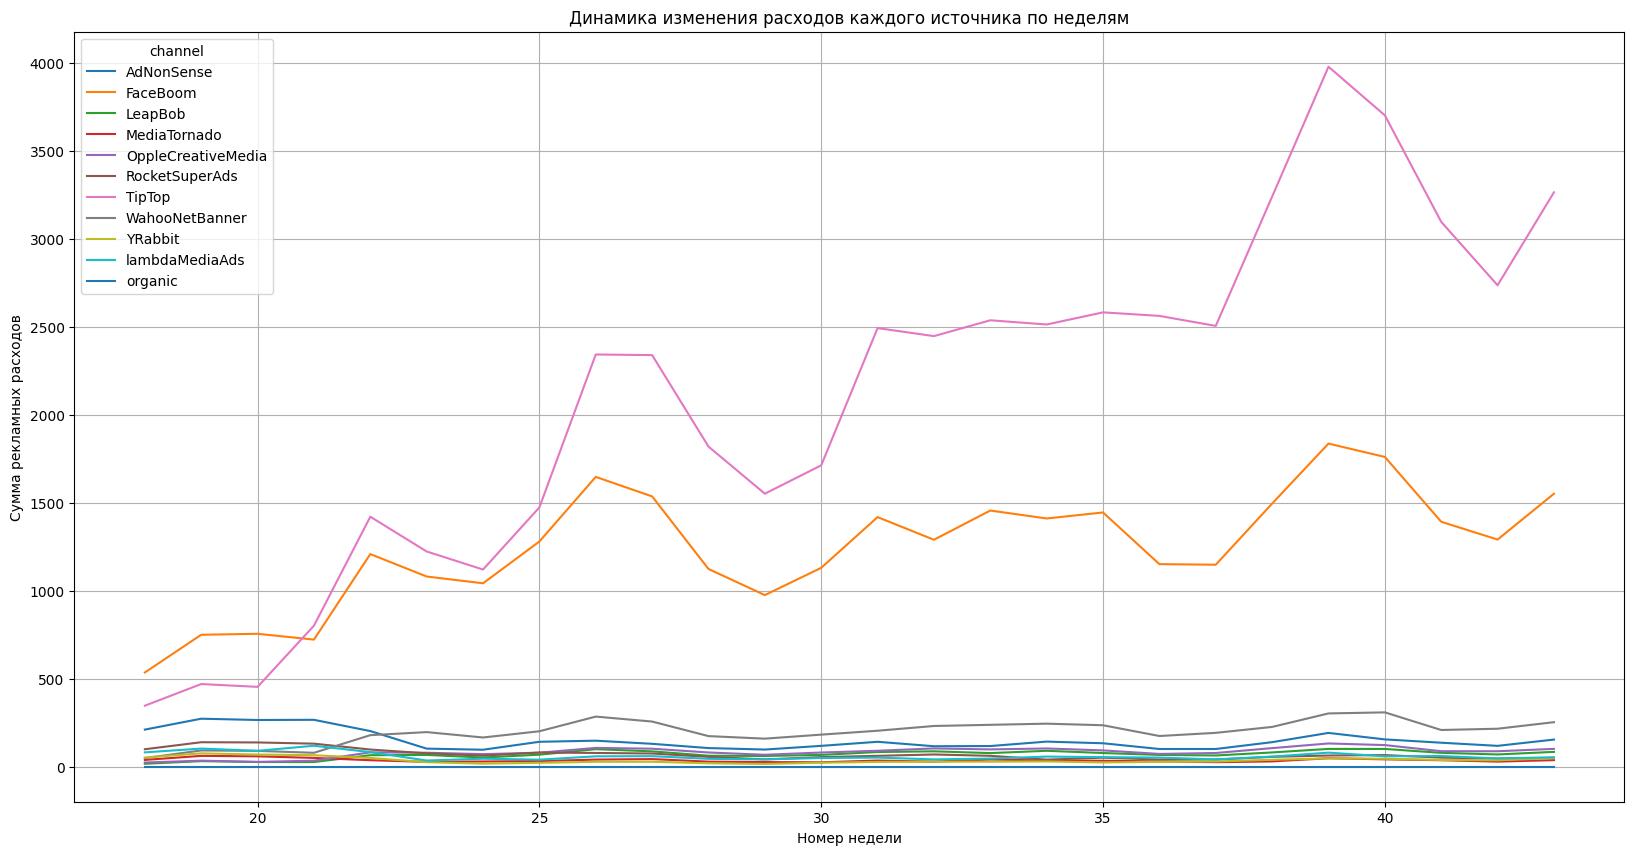

In [40]:
profiles.pivot_table(
    index="week",  # номер недели
    columns="channel",  # источники переходов
    values="acquisition_cost",  # средняя сумма расходов на пользователя по рекламному каналу
    aggfunc="sum",  # сумма расходов
).plot(
    figsize=(20, 10),
    title="Динамика изменения расходов каждого источника по неделям",
    grid=True,
)
plt.xlabel("Номер недели")
plt.ylabel("Сумма рекламных расходов")
plt.show()

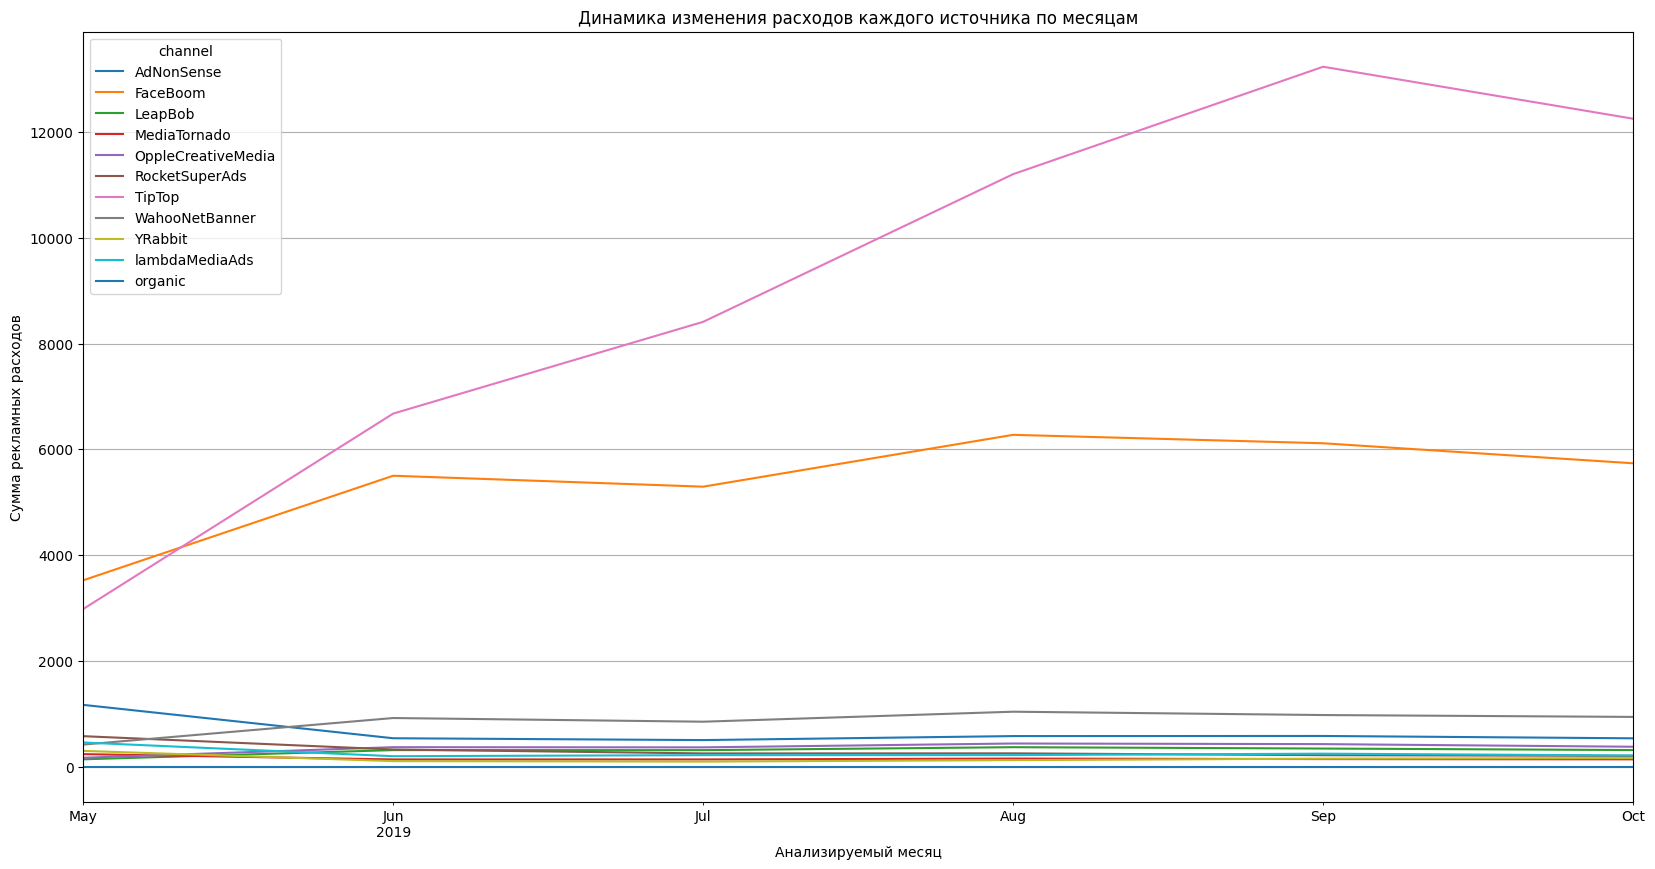

In [41]:
profiles.pivot_table(
    index="month",  # месяц
    columns="channel",  # источники переходов
    values="acquisition_cost",  # сумма расходов на пользователя
    aggfunc="sum",  # сумма расходов
).plot(
    figsize=(20, 10),
    title="Динамика изменения расходов каждого источника по месяцам",
    grid=True,
)
plt.xlabel("Анализируемый месяц")
plt.ylabel("Сумма рекламных расходов")
plt.show()

Обращаю внимание на стабильный рост расходов рекламного канала `TipTop`. С 21-ой недели расходы этого рекламного канала превысили расходы предыдущего лидера по расходам — `FaceBoom`, динамика роста расходов этого канала гораздо более умеренная. Это два основных канала. Расходы других рекламных каналов значительно ниже.  

Также фиксирую незначительное падение расходов рекламного канала `AdNonSense` с 21-ой недели 2019 года.  

Построю таблицу средней стоимости привлечения одного пользователя в разрезе рекламных каналов и отражу динамику `CAC` по каналам.

In [42]:
profiles.pivot_table(
    index="channel", values="acquisition_cost", aggfunc="mean"
).sort_values(by="acquisition_cost", ascending=False)

acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
organic                     0.000000

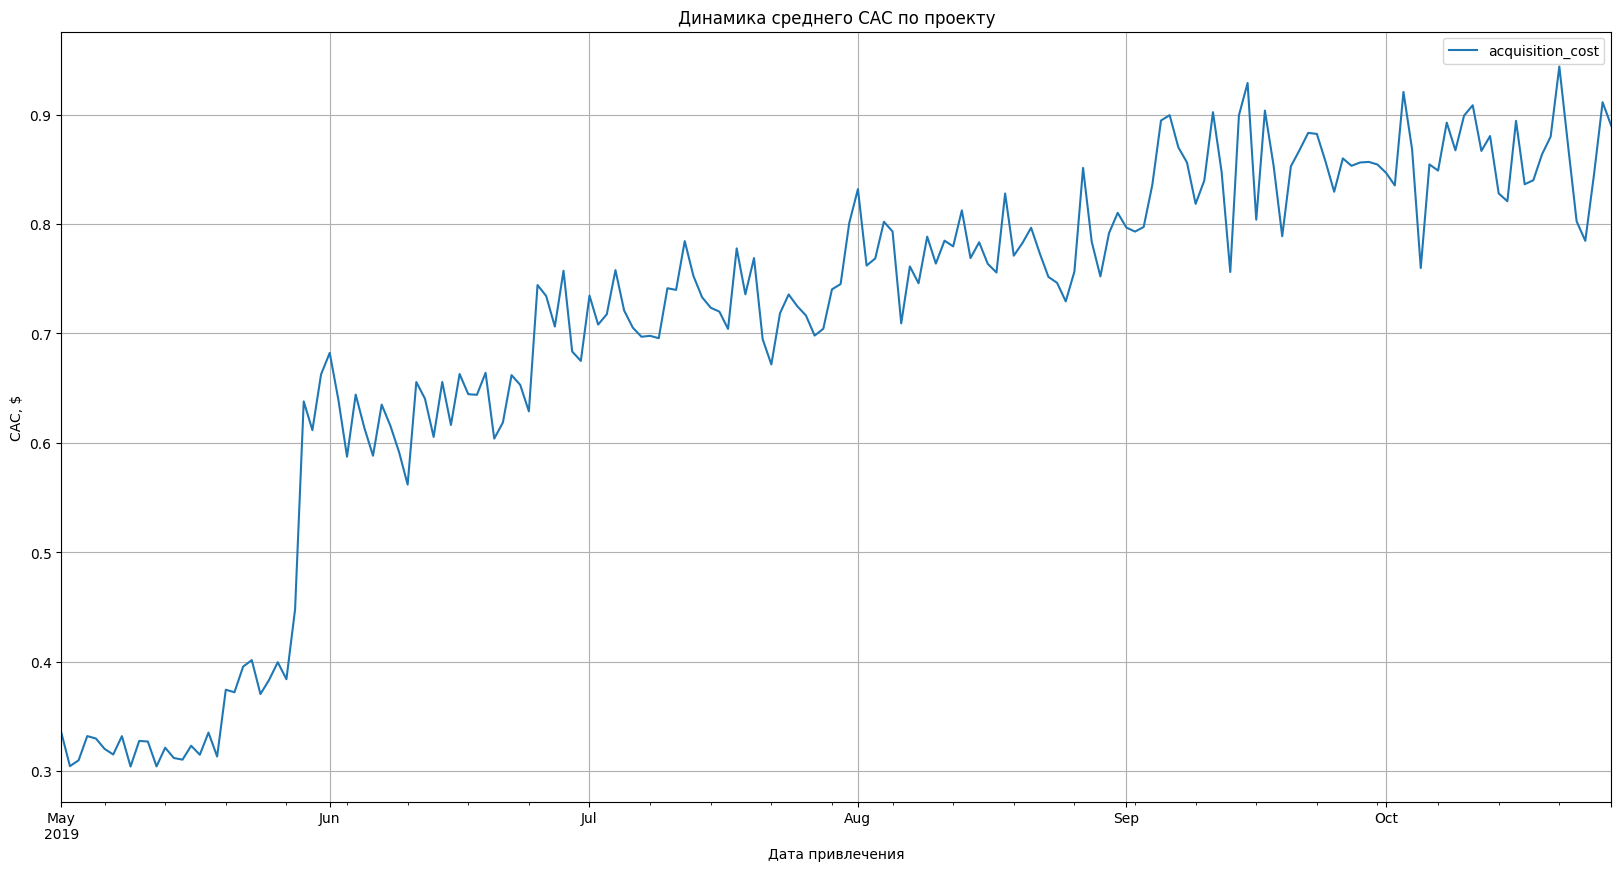

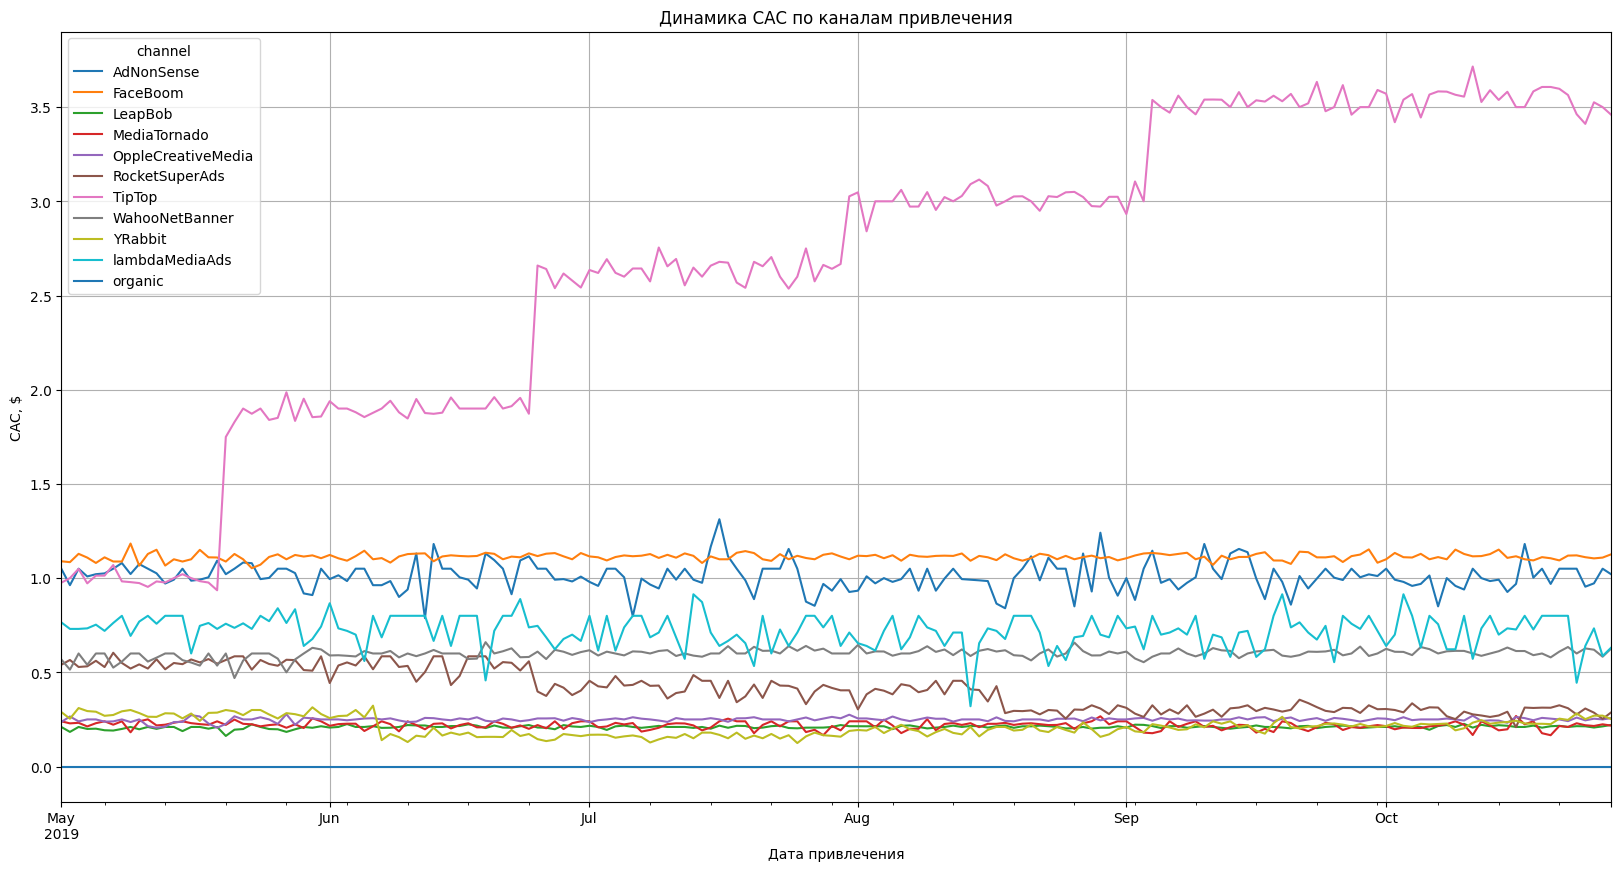

In [43]:
# строю график истории изменений среднего CAC по проекту
profiles.pivot_table(index="dt", values="acquisition_cost", aggfunc="mean").plot(
    grid=True, figsize=(20, 10)
)
plt.ylabel("CAC, $")
plt.xlabel("Дата привлечения")
plt.title("Динамика среднего САС по проекту")
plt.show()

# строю график истории изменений CAC по каналам привлечения
profiles.pivot_table(
    index="dt", columns="channel", values="acquisition_cost", aggfunc="mean"
).plot(grid=True, figsize=(20, 10))
plt.ylabel("CAC, $")
plt.xlabel("Дата привлечения")
plt.title("Динамика САС по каналам привлечения")
plt.show()

Обращаю внимание на скачкообразный ежемесячный рост стоимости привлечения пользователя через канал `TipTop`. Также обращаю внимание, что увеличение расходов на этот канал значительно отразилось на росте среднего `САС` по проекту, что видно из верхнего графика динамики  `САС`   
При том, что `CAC` других рекламных каналов более стабилен на протяжении всего периода анализа. Для роста расходов этого рекламного канала нет очевидных причин.  

Далее оценю эффективность каждого из источников в разрезе. А также оценю окупаемость рекламы в разрезе устройств и стран пользователей.

### Окупаемость рекламы (#advertising_payback)
<a id="advertising_payback"></a>

In [44]:
# указываю момент анализа
observation_date = datetime(2019, 11, 1).date()
# задаю горизонт анализа
horizon_days = 14

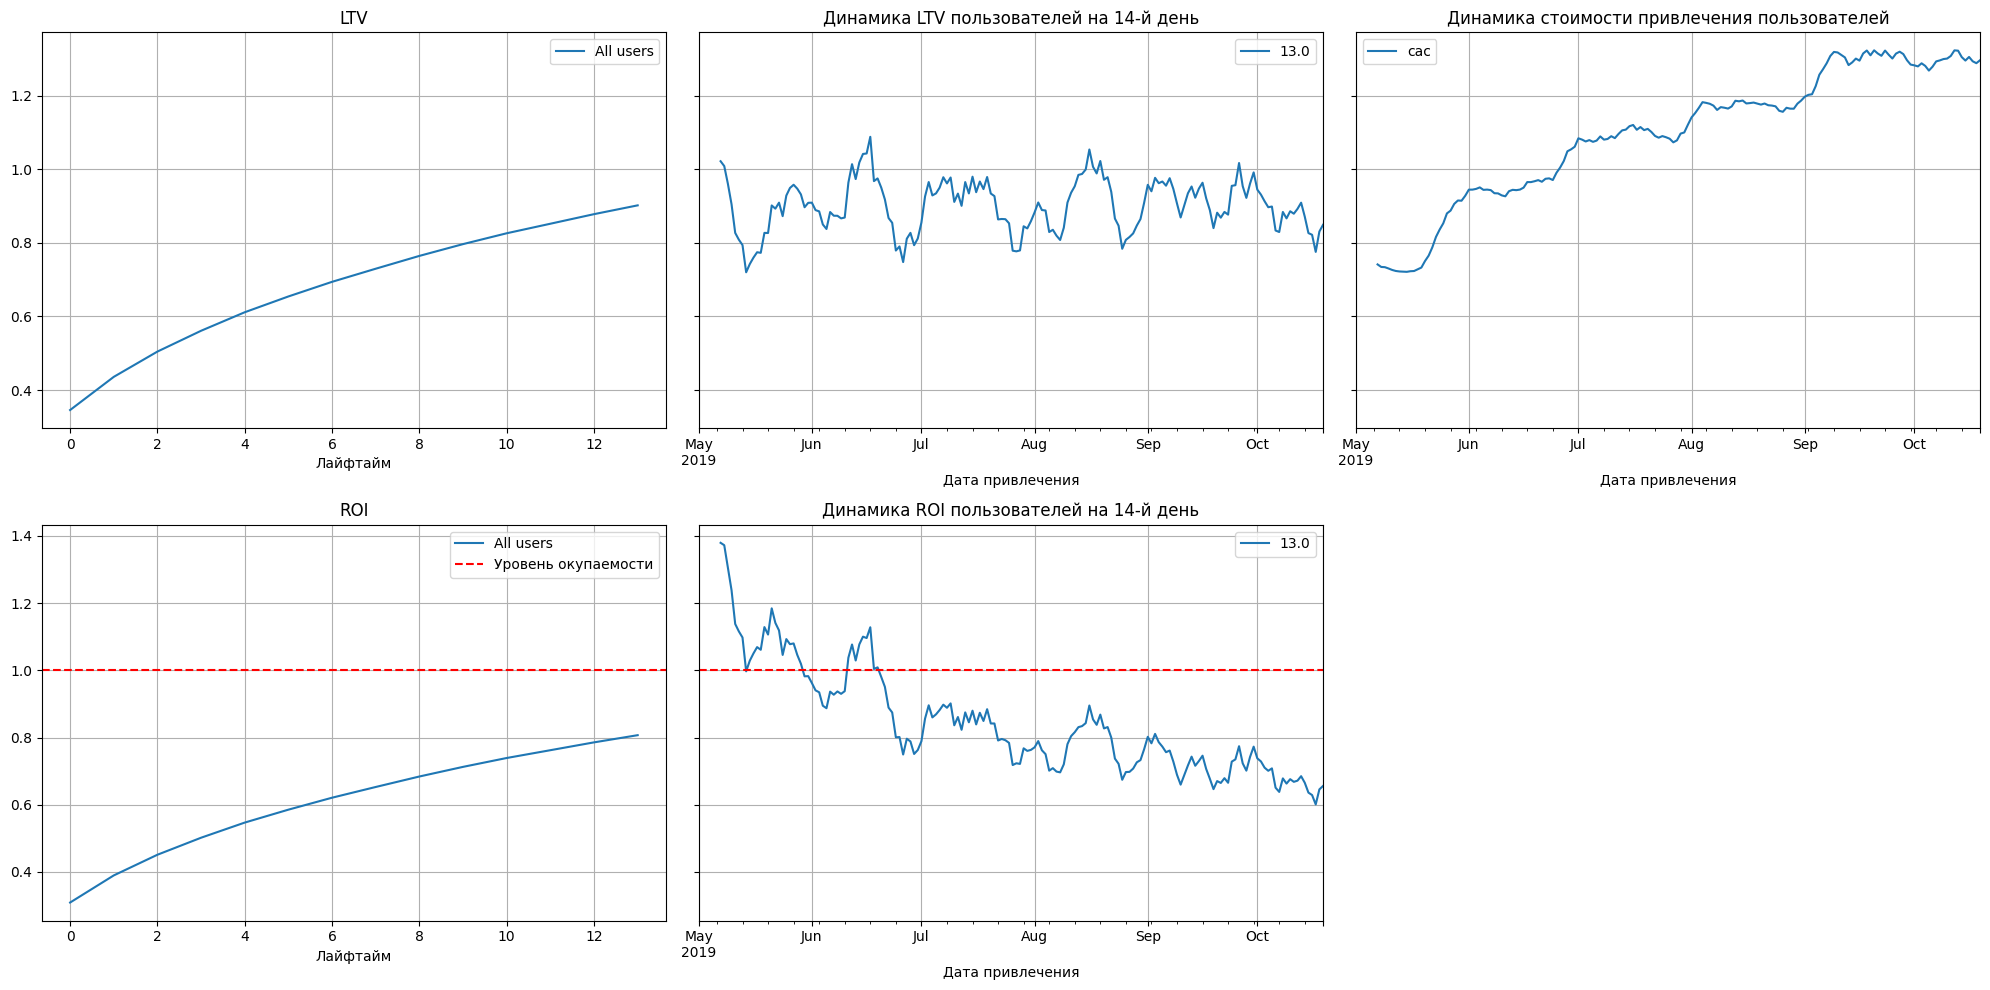

In [45]:
# перед анализом окупаемости рекламы исключаю `бесплатных пользователей`
profiles = profiles.query('channel != "organic"')

# LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
# строю графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:
- Реклама не окупается. ROI к концу 14-ого дня чуть выше 80%. Такая ситуация впервые сложилась в конце мая — начале июня, а после середины июня `ROI` уже не достигал уровня окупаемости. И до конца анализируемого периода ситуация не менялась в лучшую сторону.
- CAC постоянно растёт. Значит, популярность приложения низкая.
- График динамики LTV скачкообразный. В мае зафиксировано серьёзное падение, а впоследствии график LTV колеблется в сравнительно похожих пределах.      

Возможно, есть проблемы с удержанием пользователей. Чтобы разобраться в причинах, рассмотрим графики конверсии и удержания пользователей.

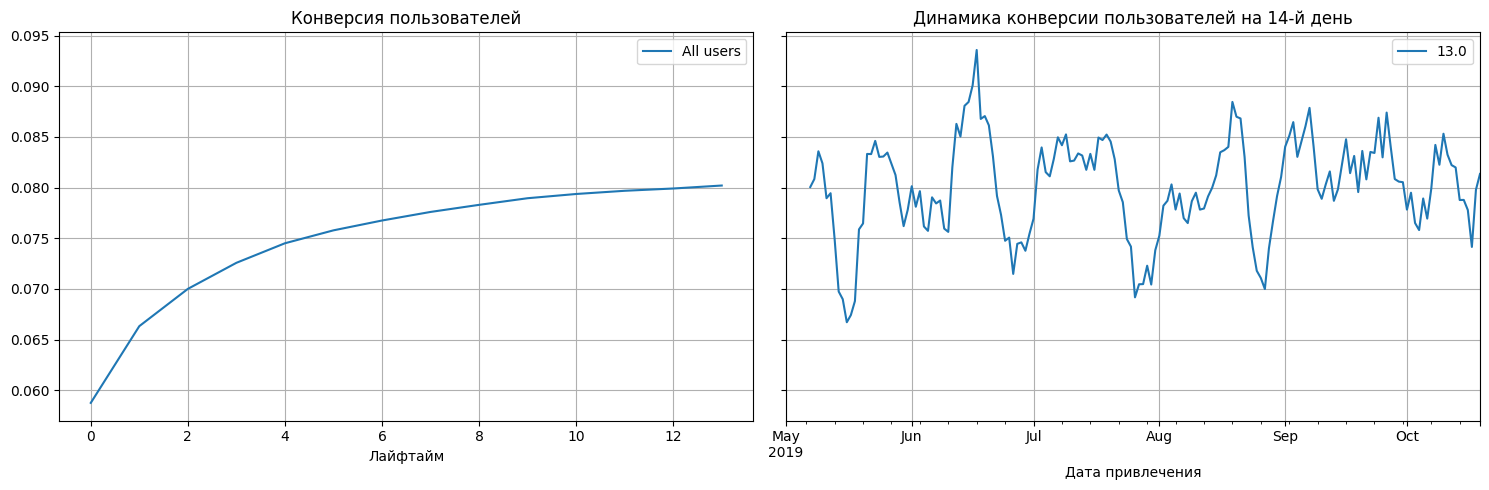

In [46]:
# смотрим график конверсии пользователей и динамику её изменения
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Обращаю внимание на скачкообразную динамику конверсии пользователей. Для поиска причин необходимо рассмотреть динамику конверсии в разрезе устройств, стран и рекламных каналов.

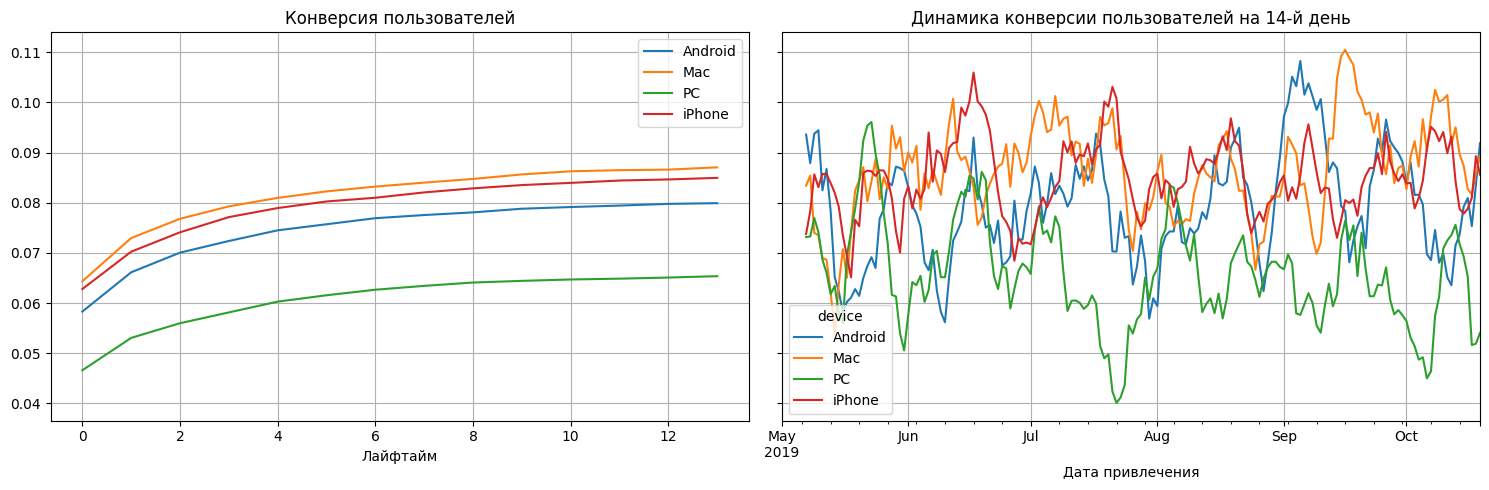

In [47]:
# смотрим график конверсии пользователей и динамику её изменения в разрезе устройств
dimensions = ["device"]
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Самые большие колебания конверсии у пользователей `PC`, при этом у них же она самая низкая. Заметные колебания также у пользователей `Android`. Проанализирую конверсию в разрезе стран.

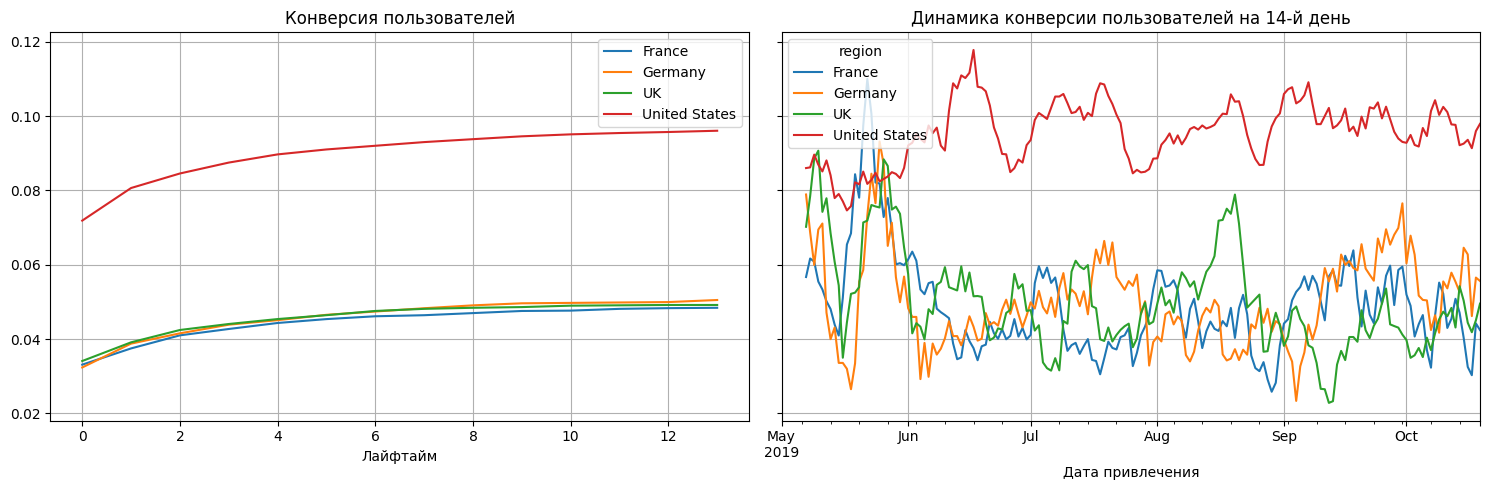

In [48]:
# смотрим график конверсии пользователей и динамику её изменения в разрезе стран
dimensions = ["region"]
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Самые низкие колебания конверсии у жителей `США`, при этом у них же самая высокая конверсия. В других странах конверсия более динамичная и гораздо ниже, чем в `США`. Проанализирую конверсию в разрезе каналов привлечения пользователей.

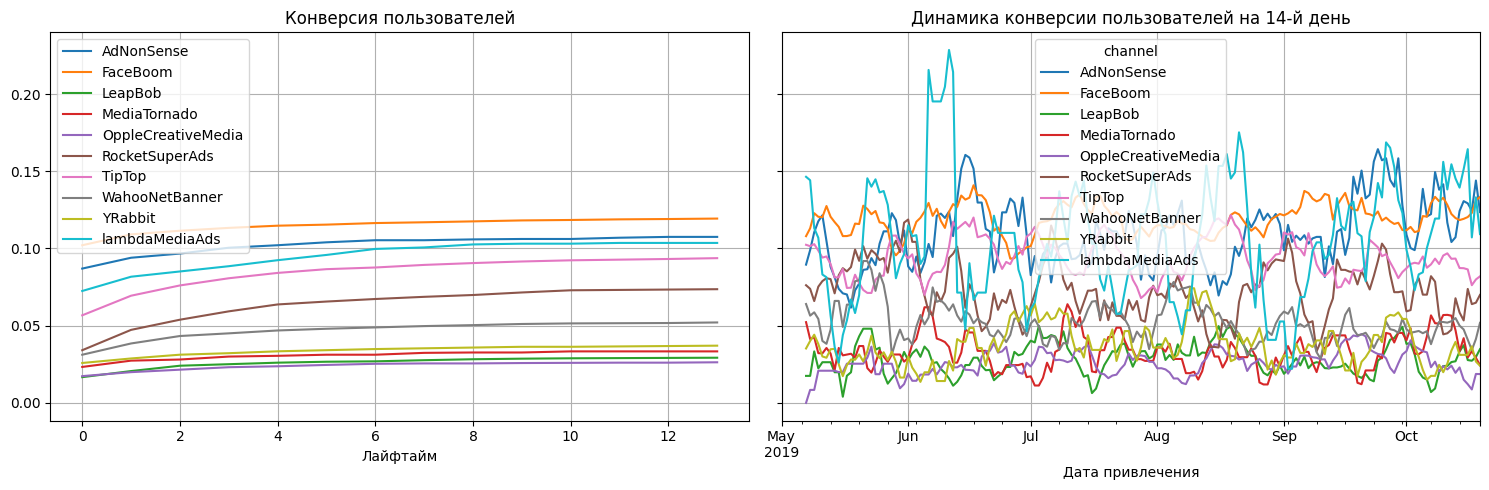

In [49]:
# смотрим график конверсии пользователей и динамику её изменения в разрезе каналов привлечения
dimensions = ["channel"]
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Обращаю внимание на скачкообразную конверсию некоторых рекламных каналов. При этом хорошую конверсию и относительную стабильность демонстрирует `FaceBoom`.

Далее рассмотрю динамику удержания пользователей. Воспользуюсь функциями `get_retention()` и `plot_retention()`.

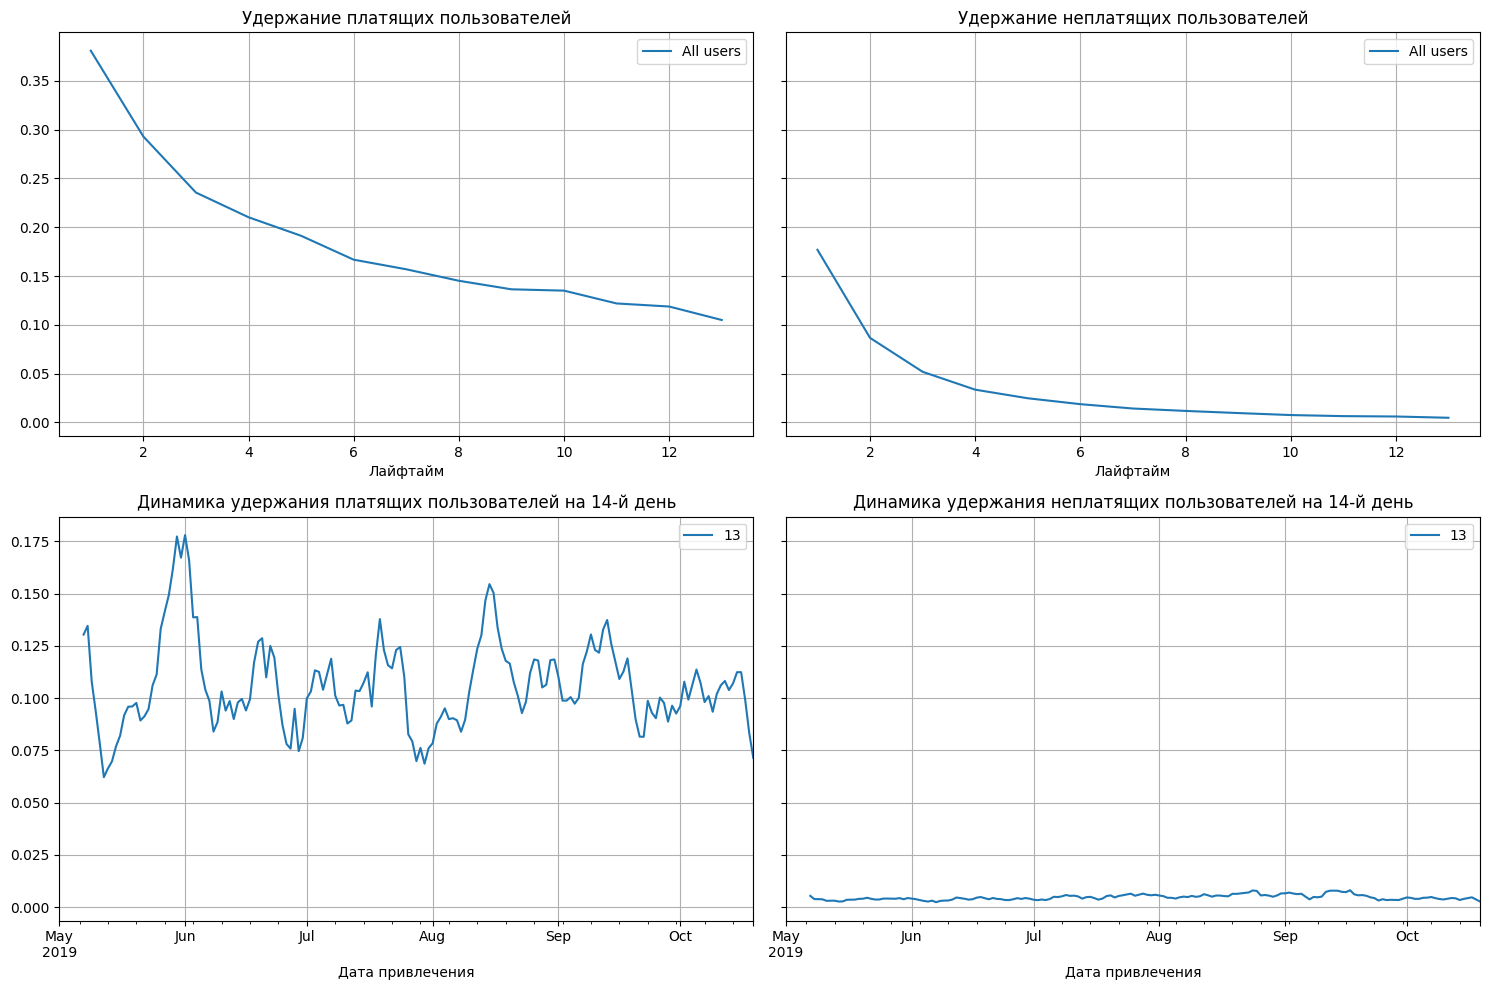

In [50]:
# смотрим удержание пользователей и динамику его изменения
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

Динамика удержания также скачкообразная. И невысокая относительно динамики неплатящих пользователей, что должно настораживать. Следует рассмотреть удержание в разрезе устройств, стран и каналов привлечения.   

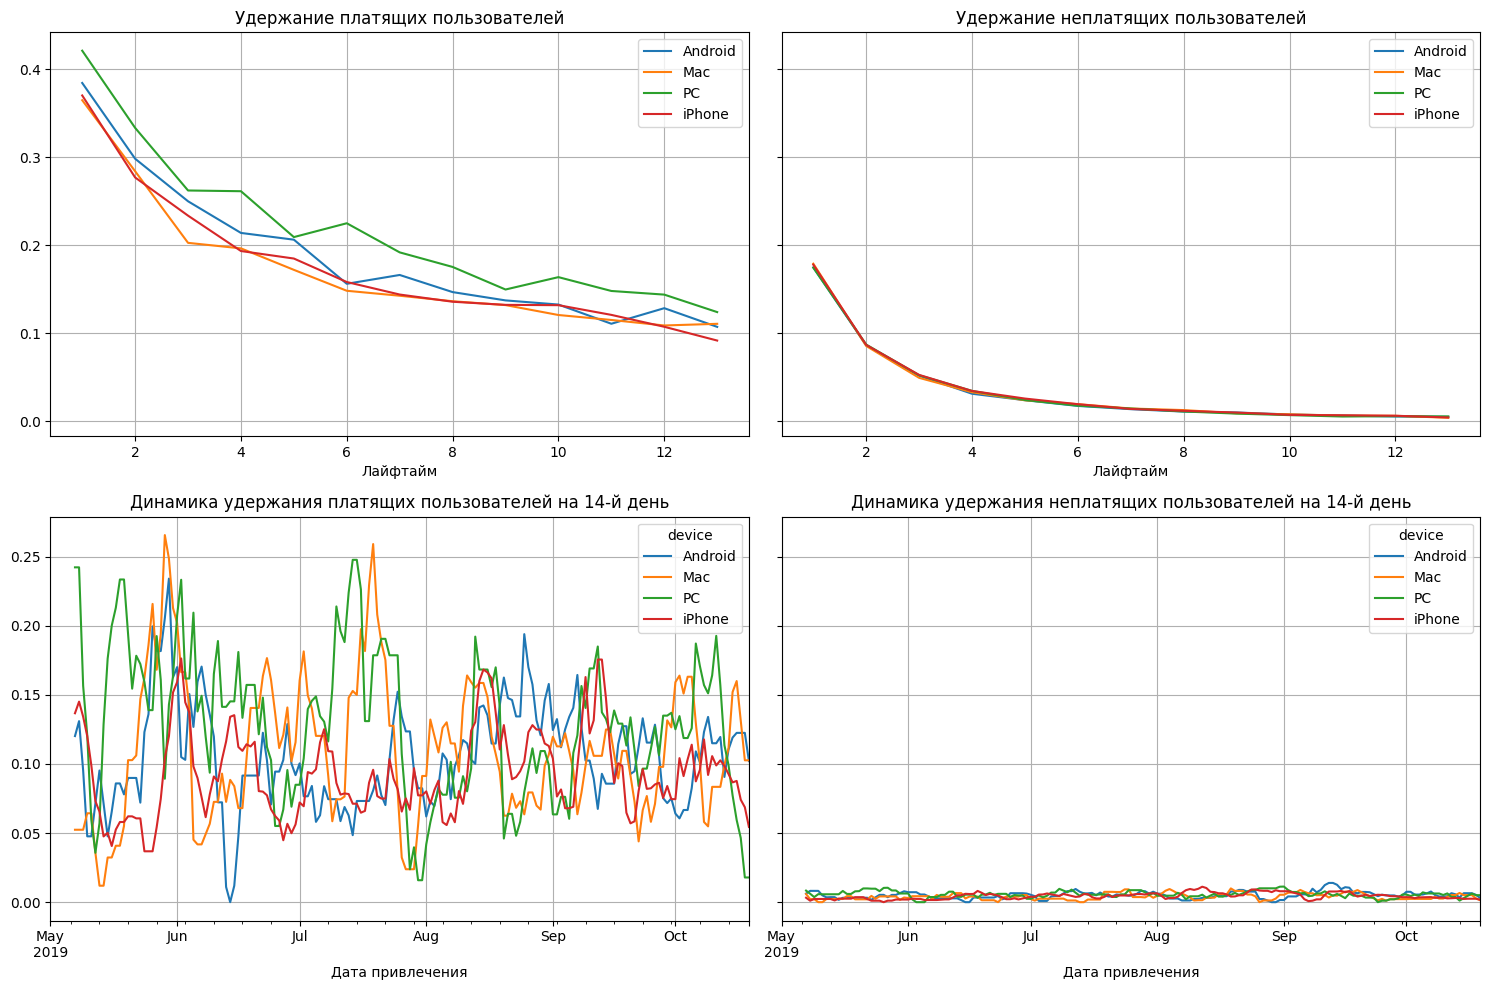

In [51]:
# смотрим удержание пользователей и динамику его изменения в разрезе устройств
dimensions = ["device"]
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Обращаю внимание, что при самой низкой динамике конверсии пользователей `PC`, у них самые высокие показзатели удержания. В то же время наблюдается обратная ситуация с пользователями `iPhone` и `Mac`. Возможно, следует проанализировать возникающие ошибки адаптации приложения для устройств `Apple`.

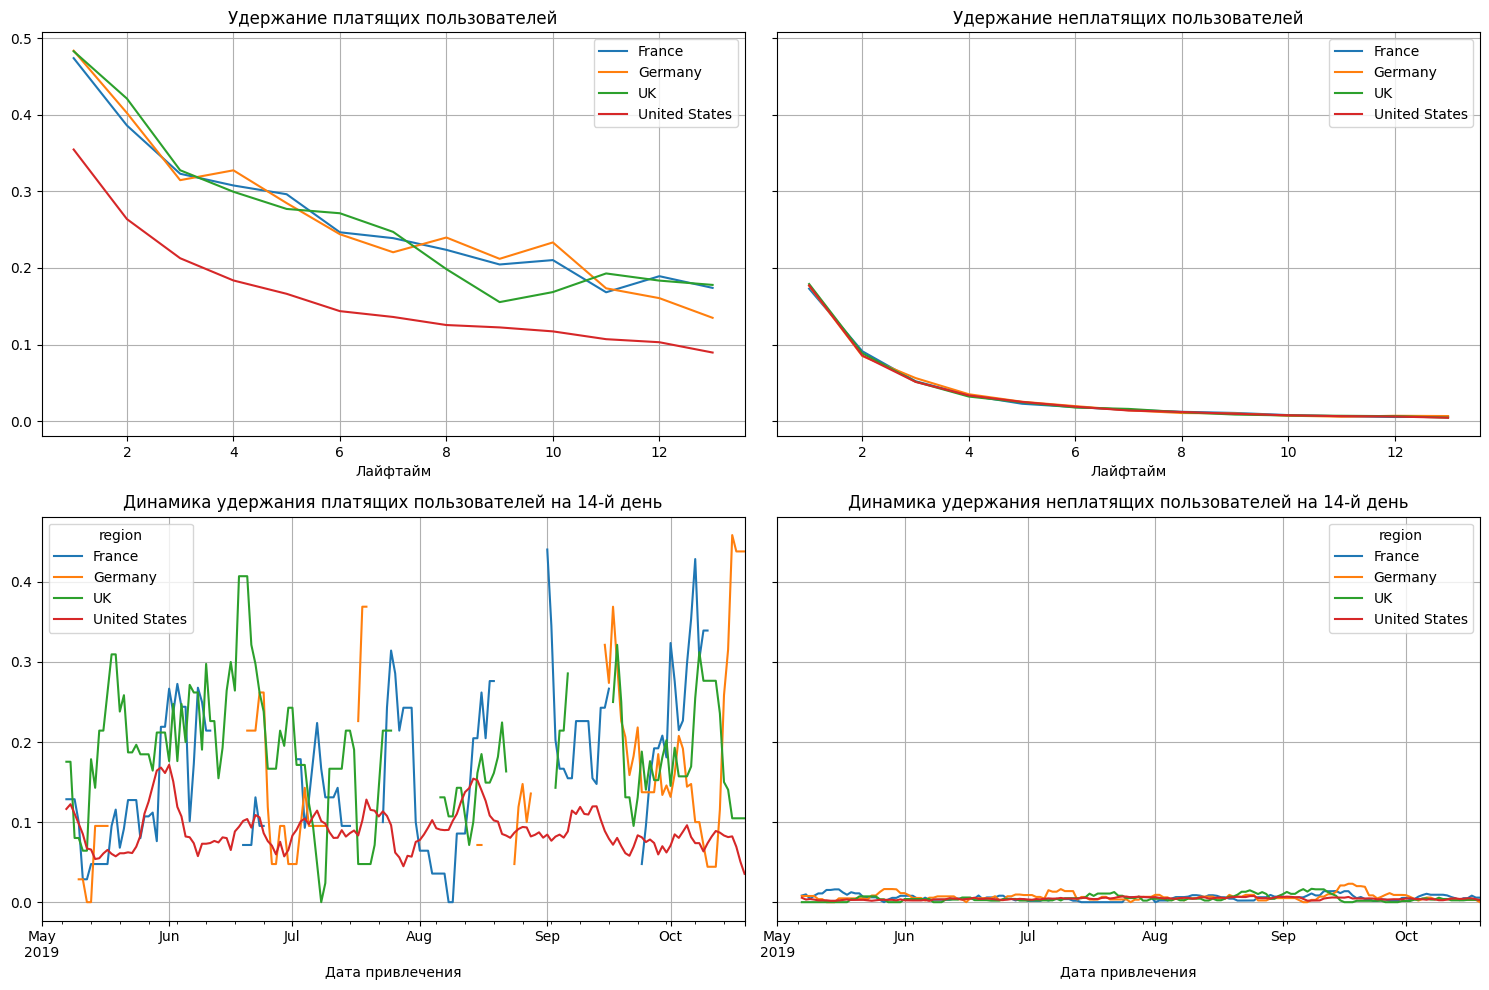

In [52]:
# смотрим удержание пользователей и динамику его изменения в разрезе стран
dimensions = ["region"]
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

График динамики удержания по странам подтверждает необходимость более подробного изучения событий при использовании приложения. В `США` с большим количеством пользователей `Apple` низкие показатели удержания пользователей. Возможно, у этой проблемы техническая природа.  

По другим странам графики прерывистые из-за недостаточного количества данных. Всё таки основные пользователи живут в `США`.

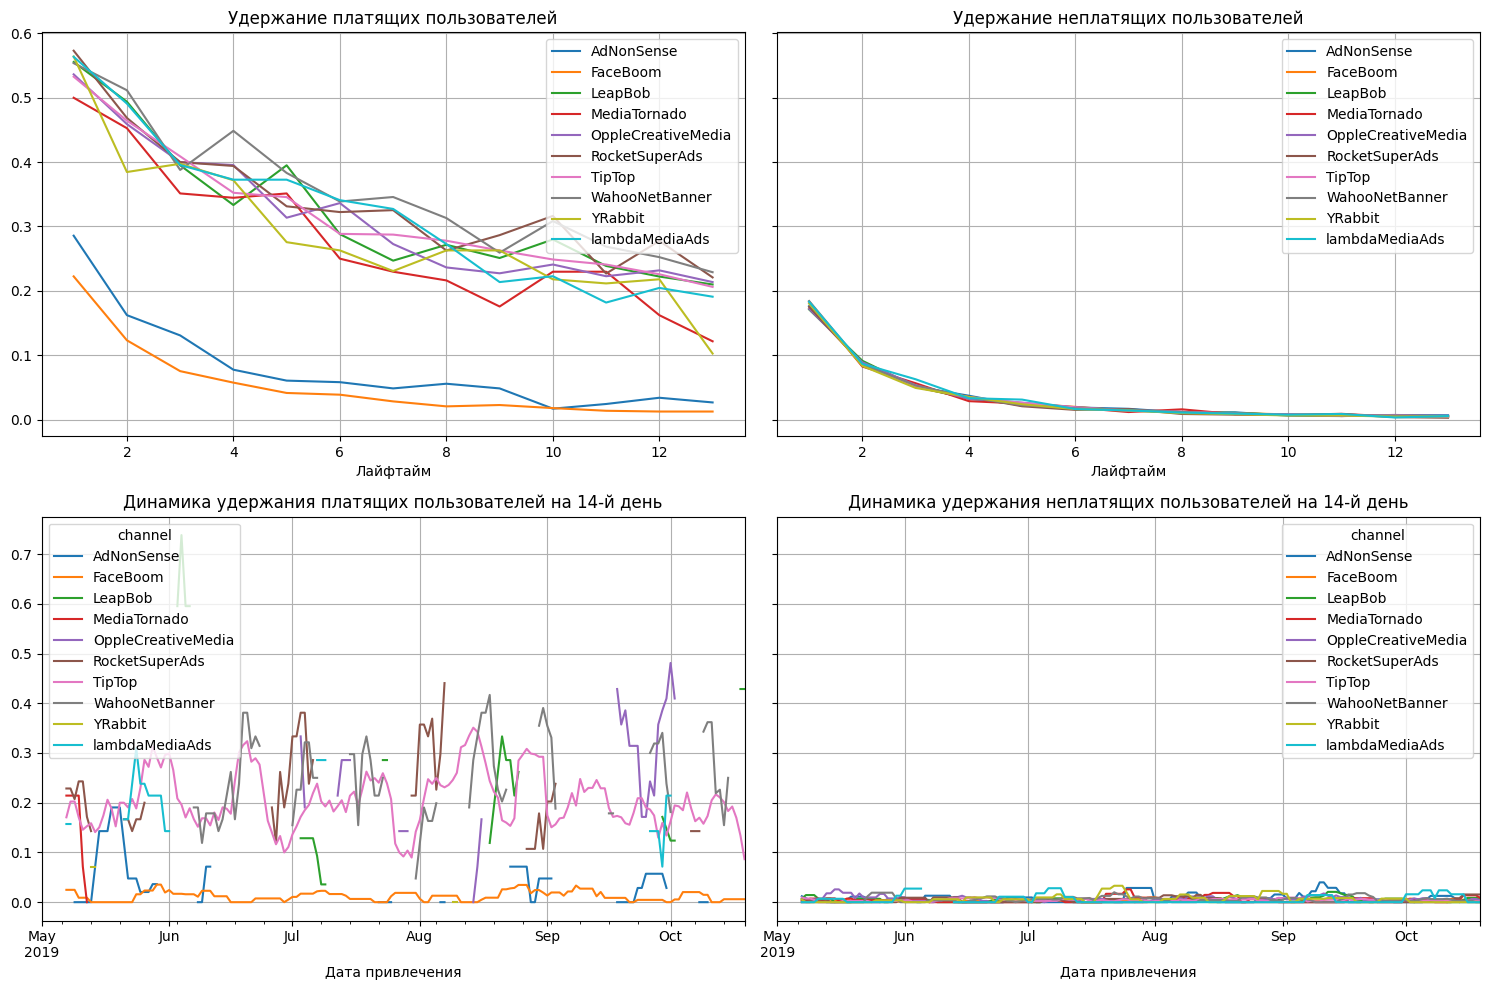

In [53]:
# удержание пользователей и динамика его изменения в разрезе рекламных каналов
dimensions = ["channel"]
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

График удержания платящих пользователей отражает самые низкие показатели удержания пользователей, привлеченных через `FaceBoom` и `AdNonSense`. Для платящих пользователей из этих каналов удержание 14-го дня ниже, чем на других каналах, примерно на 25%. Возможно, причина технического характера.  

Далее проанализирую окупаемость рекламы. Начну с анализа окупаемости рекламы в разрезе устройств: передам параметру `dimensions` столбец `device`.

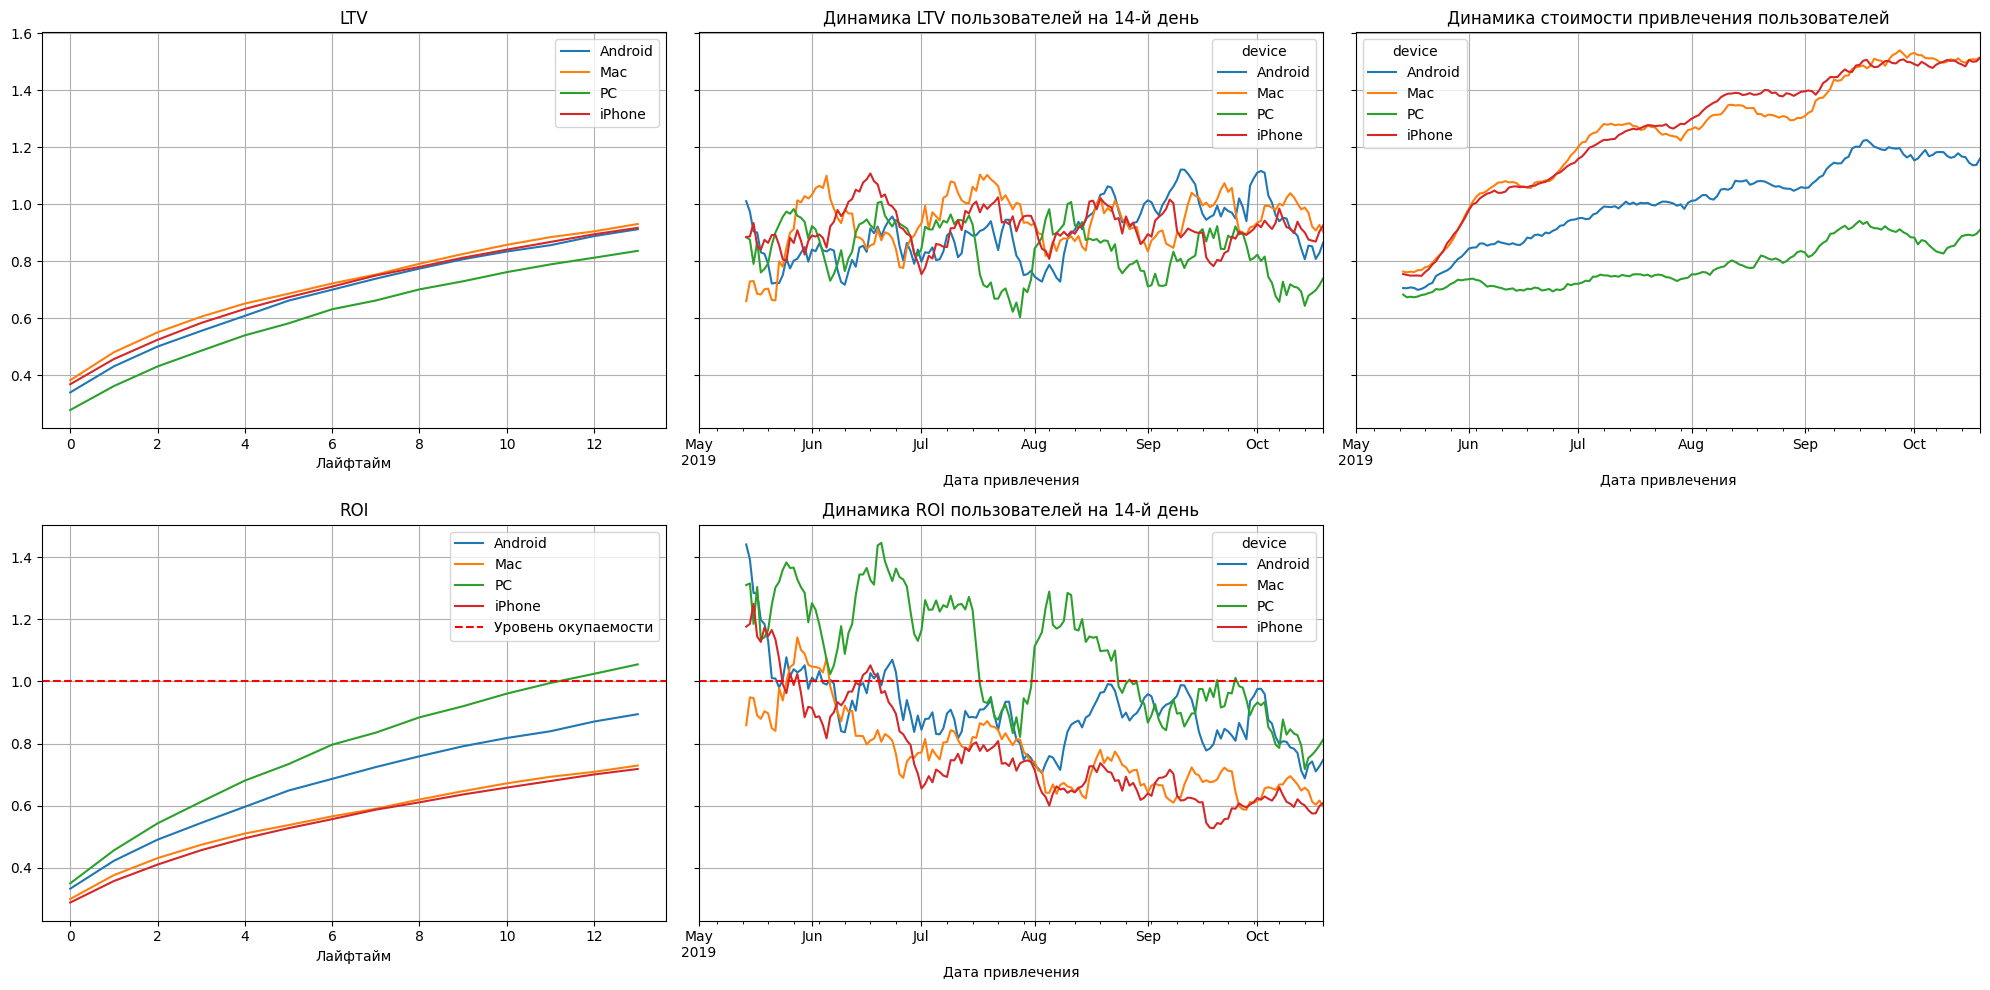

In [54]:
# окупаемость с разбивкой по устройствам
dimensions = ["device"]

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Обращаю внимание, что самая высокая стоимость привлечения пользователя у `iPhone` и `Mac`. Но пользователи этих устройств не выходят на окупаемость к 14 дню.  Также обращаю внимание, что такая ситуация с владельцами устройств `Apple` с июля 2019 года.  

При этом график динамики стоимости привлечения пользователя демонстрирует существенный и постоянный рост по этим двум устройствам. Динамика роста стоимости "неяблочных" устройств замтено ниже.

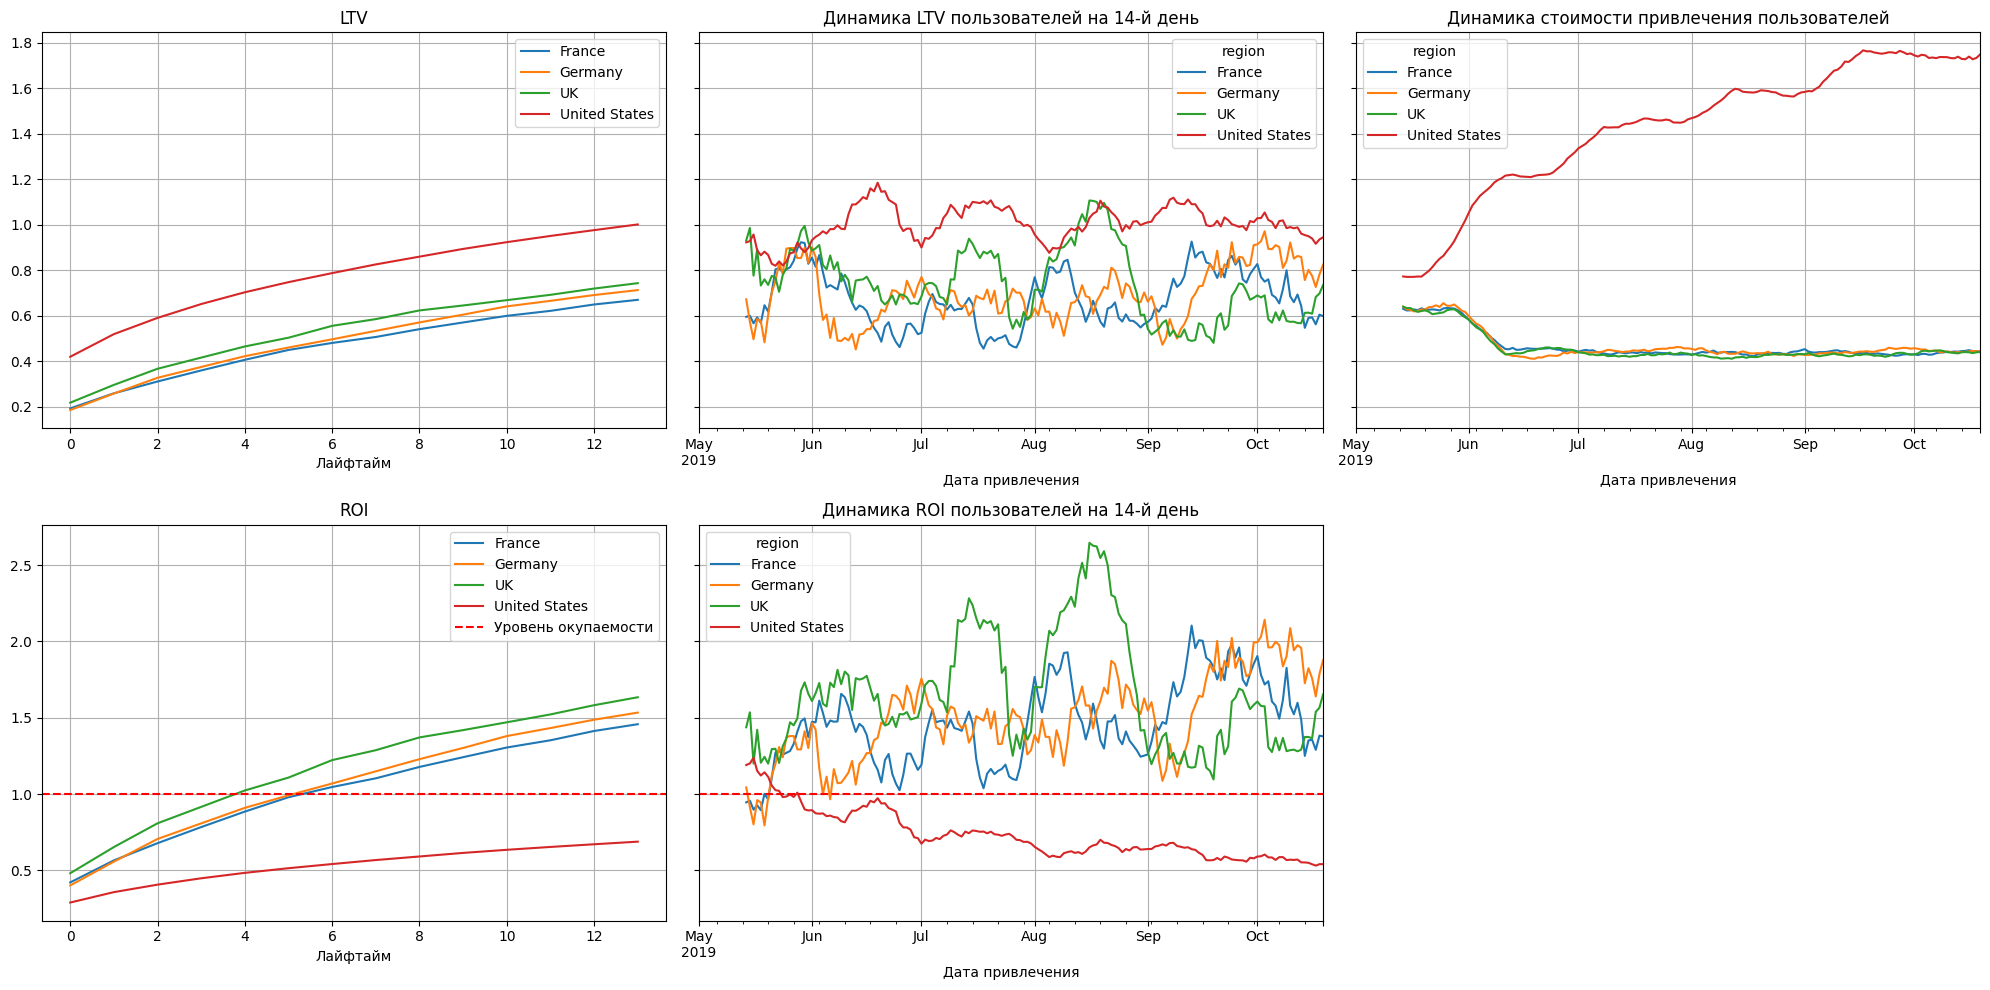

In [55]:
# окупаемость с разбивкой по странам
dimensions = ["region"]

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Графики динамики по странам подсвечивают `проблемную страну — США`. Негативная динамика `ROI` отражена с июля 2019 года, после этого привлечение пользователей из США не вышло на окупаемость, стоимость привлечения пользователей в разы выше чем в других странах.  

Рассмотрю динамику показателей в разрезе рекламных каналов.

По графикам можно сделать такие выводы:

1. Реклама окупилась по всем странам, кроме `USA`.
2. Компания наращивала расходы на маркетинг по USA. Стоимость привлечения для других стран стабильна.

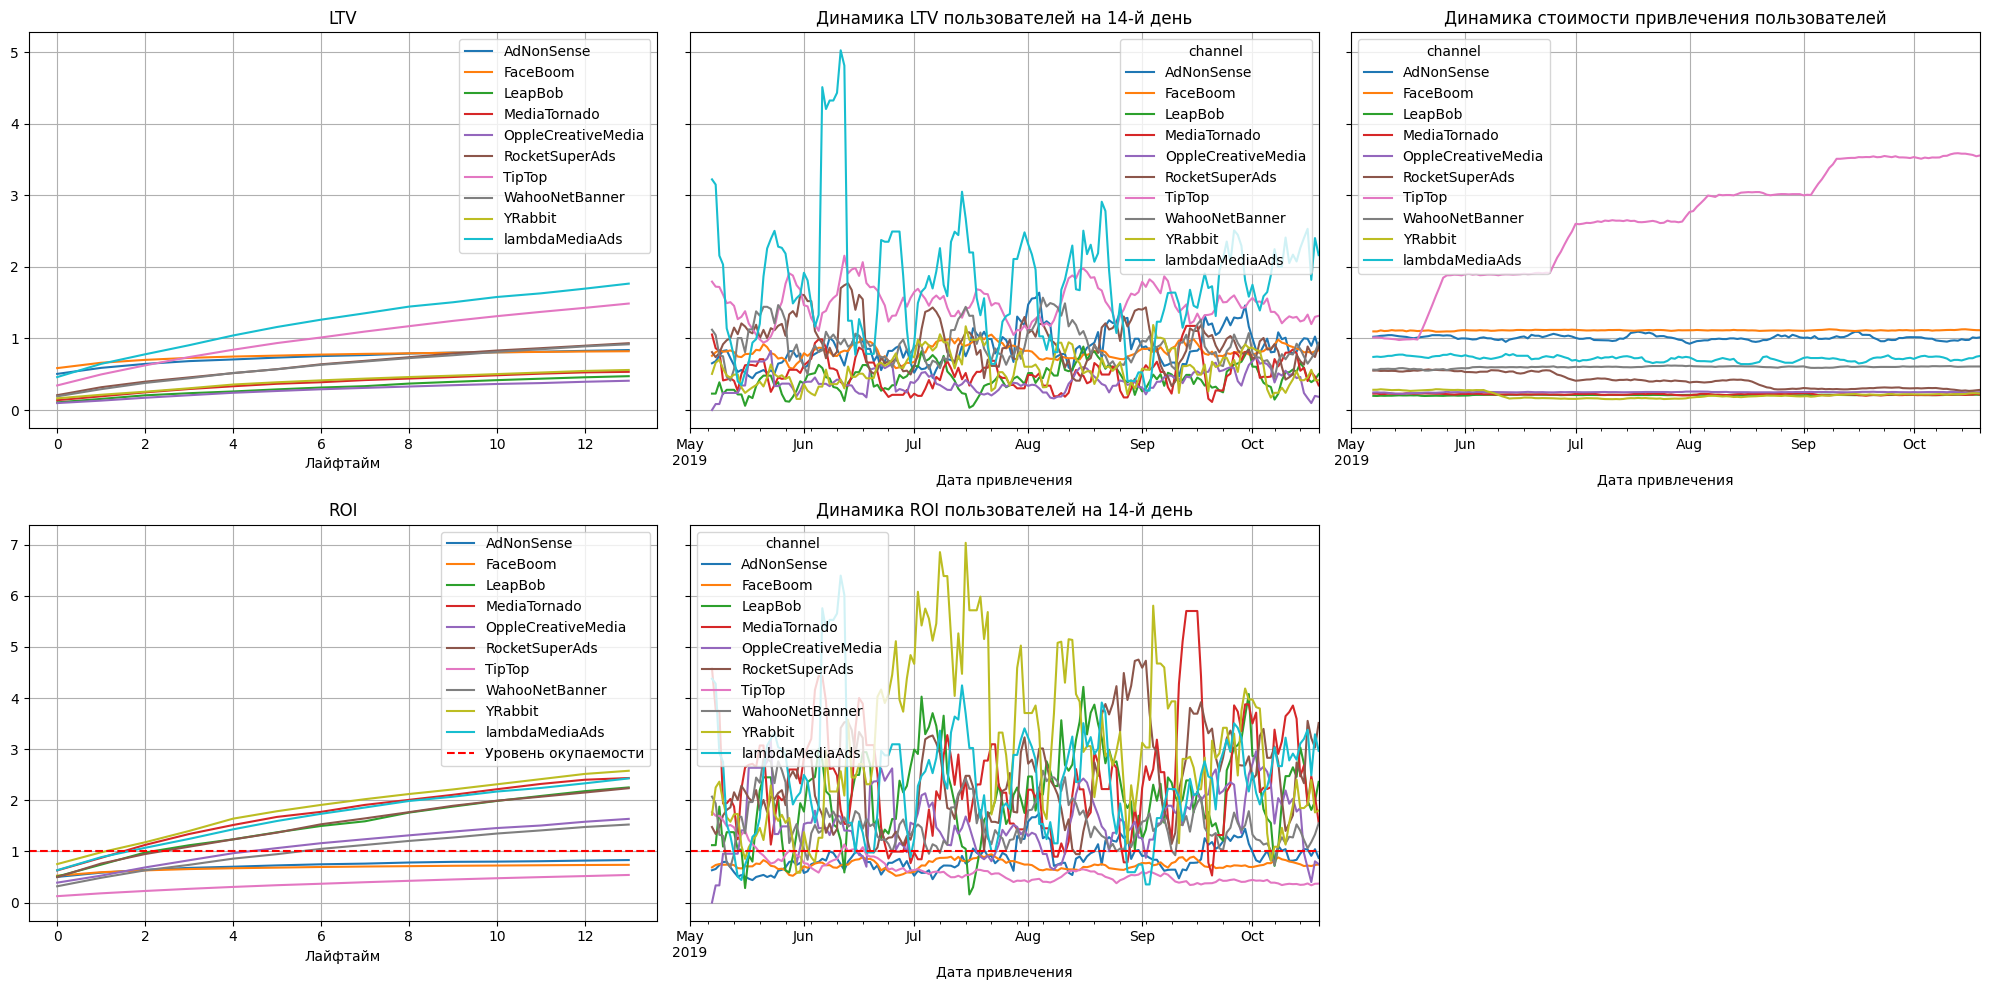

In [56]:
# нахожу LTV с разбивкой по каналам привлечения
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=["channel"]
)

# строю графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

"Проблемными каналами" привлечения пользователей, не вышедших на окупаемость стали наиболее затратные `FaceBoom`, `TipTop` и `AdNonSense`, их неэффективность была отмечена и на предыдущих этапах анализа.

По графикам можно сделать такие выводы:

1. Окупились все каналы, кроме `TipTop`, `FaceBoom` и `AdNonSense`.
2. В течение всего периода `САС` был стабилен по всем каналам, кроме `TipTop`. Компания по каналу `TipTop` значительно наращивала расходы по маркетингу в течение всего периода проекта.

*Общий вывод:*

1. Расходы на рекламу приложения за весь период проекта не окупился, не хватило пару процентов.
2. Окупилась реклама на всех каналах, кроме `TipTop`, `FaceBoom` и `AdNonSense`.
3. На `TipTop` компания ежемесячно значительно увеличивает расходы на привлечение пользователей при низких показателях окупаемости канала.
4. Пользователи `FaceBoom` и `AdNonSense` имеют высокую конвертацию , при этом привлечённые пользователи плохо удерживаются.

## Выводы (#conclusion)
<a id="conclusion"></a>

- В процессе анализа было выявлено:
    - некорректное распределение рекламных бюджетов по каналам с точки зрения корреляции стоимости привлечения пользователей и удержания;
    - некорректное распределение рекламных бюджетов по странам с точки зрения корреляции стоимости привлечения пользователей и окупаемости.


✍
Общий вывод

Реклама приложения за весь период окупилась чуть более чем на 80%. Большая часть расходов пришлась на США, оттуда основной поток платящих пользователей.

- Причинами неокупаемости рекламы в `США` стали:
   - наращивание стоимости привлечения пользователей канала TipTop для `США`, это видно из прямой корреляции роста расходов на `Tip-Top` и роста `CAC` в `USA`
   - предположительно стоит более детально сегментировать аудиторию `TipTop` и привлекать только платёжеспособные сегменты канала. Также можно предложить снизить расходы на рекламу канала `TipTop`, если такие сегменты не будут выявлены;
   - стоит рассмотреть техническую сторону приложения `Procrastinate Pro+`, а именно адаптацию приложения для продуктов компании `Apple`. На данный момент при самых высоких показателях конверсии пользователей этих устройств, они хуже всех удерживаются.
   - возможно, это и стало причиной низких показателей удержания рекламных каналов `FaceBoom` и `AdNonSense`. Стоит проанализировать техническую сторону работы приложения. 
- Рекомендации: 
    - пересмотреть приоритетность распределения рекламных бюджетов по каналам привлечения в пользу тех, что демонстрируют положительную динамику и хороший уровень окупаемости: `YRabbit`, `MediaTornado`, `LambdaMediaAds`
    - пользователи с рекламыа `LambdaMediaAds` демонстрирует хорошую конверсию, LTV и окупаемость. Возможно, стоит увеличить рекламные бюджеты этого канала в `Германии` и `UK`. При хороших показателях рассмотреть увеличение бюджетов и других окупаемых каналов в этих странах.
    - уменьшить рекламные бюджеты "проблемных" `FaceBoom`, `TipTop` и `AdNonSense`. При высокой конверсии эти каналы не выходят на окупаемость из-за низких показателей удержания (технические проблемы?);
    - изучить возможные технические ошибки работы приложения на устройствах `Apple`
    - изучение конкурентов рынка США, поиск возможных ожиданий потенциальных пользователей, ошибок в адаптации приложения для пользователей США.